<a href="https://colab.research.google.com/github/amirshirazieng/MyMachineLearningSampleCode/blob/Sample/FaultDetectionInMotorViaCNN_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount the google drive path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from keras import layers, optimizers, losses
from keras.layers import Dense, Dropout
import keras
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import re
import scipy.io
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D,Conv1D,MaxPooling1D
from keras.layers.core import Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Activation
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import keras
print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [ ]:
matlab_files_name = {}
 
def cwru_12khz():
  # Normal
  matlab_files_name["B007_1_123"] = "/content/drive/MyDrive/Shirazi/raw/B007_1_123.mat"
  matlab_files_name["B014_1_190"] = "/content/drive/MyDrive/Shirazi/raw/B014_1_190.mat"
  matlab_files_name["B021_1_227"] = "/content/drive/MyDrive/Shirazi/raw/B021_1_227.mat"
  matlab_files_name["IR007_1_110"] = "/content/drive/MyDrive/Shirazi/raw/IR007_1_110.mat"
  matlab_files_name["IR014_1_175"] = "/content/drive/MyDrive/Shirazi/raw/IR014_1_175.mat"
  matlab_files_name["IR021_1_214"] = "/content/drive/MyDrive/Shirazi/raw/IR021_1_214.mat"
  matlab_files_name["OR007_6_1_136"] = "/content/drive/MyDrive/Shirazi/raw/OR007_6_1_136.mat"
  matlab_files_name["OR014_6_1_202"] = "/content/drive/MyDrive/Shirazi/raw/OR014_6_1_202.mat"
  matlab_files_name["OR021_6_1_239"] = "/content/drive/MyDrive/Shirazi/raw/OR021_6_1_239.mat"
  matlab_files_name["Time_Normal_1_098"] = "/content/drive/MyDrive/Shirazi/raw/Time_Normal_1_098.mat"
  return matlab_files_name

In [ ]:
def get_tensors_from_matlab(matlab_files_name):  
  acquisitions = {}
  for key in cwru_12khz():
    file_name = matlab_files_name[key]
    matlab_file = scipy.io.loadmat(file_name)
    for position in ['DE']:
      keys = [key for key in matlab_file if key.endswith(position+"_time")]
      if len(keys)>0:
        array_key = keys[0]
        acquisitions[key] = matlab_file[array_key].reshape(1,-1)[0]
  return acquisitions

In [ ]:
def cwru_segmentation(acquisitions, sample_size=512, max_samples=None):
  '''
  Segments the acquisitions.
  sample_size is the size of each segment.
  max_samples is used for debug purpouses and 
  reduces the number of samples from each acquisition.
  '''
  origin = []
  data = np.empty((0,sample_size,1))
  n = len(acquisitions)
  for i,key in enumerate(acquisitions):
    acquisition_size = len(acquisitions[key])
    n_samples = acquisition_size//sample_size
    if max_samples is not None and max_samples > 0 and n_samples > max_samples:
      n_samples = max_samples
    print('{}/{} --- {}: {}'.format(i+1, n, key, n_samples))
    origin.extend([key for _ in range(n_samples)])
    data = np.concatenate((data,
           acquisitions[key][:(n_samples*sample_size)].reshape(
               (n_samples,sample_size,1))))
  return data,origin

In [ ]:
def select_samples(regex, X, y):
  '''
  Selects samples wich has some regex pattern in its name.
  '''
  mask = [re.search(regex,label) is not None for label in y]
  return X[mask],y[mask]

In [ ]:
def join_labels(regex, y):
  '''
  Excludes some regex patterns from the labels, 
  making some samples to have the same label.
  '''
  return np.array([re.sub(regex, '', label) for label in y])

In [ ]:
def get_groups(regex, y):
  '''
  Generates a list of groups of samples with 
  the same regex patten in its label.
  '''
  groups = list(range(len(y)))
  for i,label in enumerate(y):
    match = re.search(regex,label)
    groups[i] = match.group(0) if match else None
  return groups

In [ ]:
matlab_files_name = cwru_12khz()
matlab_files_name
acquisitions = get_tensors_from_matlab(matlab_files_name)
list(acquisitions.keys())

['B007_1_123',
 'B014_1_190',
 'B021_1_227',
 'IR007_1_110',
 'IR014_1_175',
 'IR021_1_214',
 'OR007_6_1_136',
 'OR014_6_1_202',
 'OR021_6_1_239',
 'Time_Normal_1_098']

In [ ]:
acquisitions.get('B007_1_123').shape

(487384,)

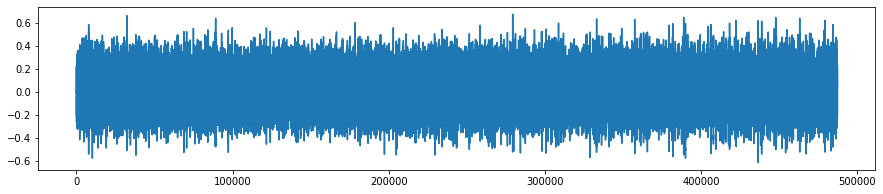

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(acquisitions.get('B007_1_123'))

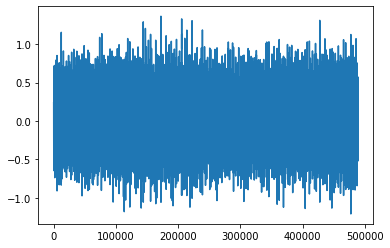

In [ ]:
plt.plot(acquisitions.get('IR014_1_175'))

In [ ]:
signal_data,signal_origin = cwru_segmentation(acquisitions, 256)

1/10 --- B007_1_123: 1903
2/10 --- B014_1_190: 1899
3/10 --- B021_1_227: 1901
4/10 --- IR007_1_110: 1899
5/10 --- IR014_1_175: 1910
6/10 --- IR021_1_214: 1894
7/10 --- OR007_6_1_136: 1901
8/10 --- OR014_6_1_202: 1892
9/10 --- OR021_6_1_239: 1910
10/10 --- Time_Normal_1_098: 1890


In [ ]:
signal_data.shape

(18999, 256, 1)

In [ ]:
def samples_relabel(regex, rp, y):
  '''
  Selects samples wich has some regex pattern in its name.
  '''
  mask = [re.search(regex,label) is not None for label in y]
  y[mask]=rp
  return y

In [ ]:
relabel_signal = np.array(signal_origin)
regex = '^(B007_1_123).*'
rp = 'B007_1_123'
relabel_signal = samples_relabel(regex, rp, relabel_signal)

regex = '^(B014_1_190).*'
rp = 'B014_1_190'
relabel_signal = samples_relabel(regex, rp, relabel_signal)
regex = '^(B021_1_227).*'
rp = 'B021_1_227'
relabel_signal = samples_relabel(regex, rp, relabel_signal)
regex = '^(IR007_1_110).*'
rp = 'IR007_1_110'
relabel_signal = samples_relabel(regex, rp, relabel_signal)
regex = '^(IR014_1_175).*'
rp = 'IR014_1_175'
relabel_signal = samples_relabel(regex, rp, relabel_signal)


regex = '^(IR021_1_214).*'
rp = 'IR021_1_214'
relabel_signal = samples_relabel(regex, rp, relabel_signal)
regex = '^(OR007_6_1_136).*'
rp = 'OR007_6_1_136'
relabel_signal = samples_relabel(regex, rp, relabel_signal)
regex = '^(OR014_6_1_202).*'
rp = 'OR014_6_1_202'
relabel_signal = samples_relabel(regex, rp, relabel_signal)
regex = '^(OR021_6_1_239).*'
rp = 'OR021_6_1_239'
relabel_signal = samples_relabel(regex, rp, relabel_signal)

regex = '^(Time_Normal_1_098).*'
rp = 'Time_Normal_1_098'
relabel_signal = samples_relabel(regex, rp, relabel_signal)


#print(a)
np.where(relabel_signal == "B014_1_190")

(array([1903, 1904, 1905, ..., 3799, 3800, 3801]),)

In [ ]:
samples = '^(IR)|(B0).*'
X,y = select_samples(samples, signal_data, relabel_signal)
print(len(set(y)),set(y))

6 {'IR014_1_175', 'B021_1_227', 'IR021_1_214', 'B007_1_123', 'B014_1_190', 'IR007_1_110'}


In [ ]:
np.size(np.where(y == "B014_1_190"))

1899

In [ ]:
X[1421].shape

(256, 1)

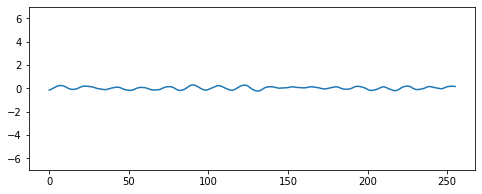

In [ ]:
plt.figure(figsize=(8,3))
plt.ylim([-7,7])
plt.plot(X[1400])

In [ ]:
labels = pd.Categorical(y, categories = set(y)).codes
labels

array([3, 3, 3, ..., 2, 2, 2], dtype=int8)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, shuffle=True)

In [ ]:
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))
nsamples2, nx, ny = X_test.shape
d3_train_dataset = X_test.reshape((nsamples2,nx*ny))

In [ ]:
X_train.shape
d2_train_dataset.shape

(8554, 256)

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(d2_train_dataset,y_train)
print("SVM accuracy is {} on Train Dataset".format(svm.score(d2_train_dataset,y_train)))
print("SVM accuracy is {} on Test Dataset".format(svm.score(d3_train_dataset,y_test)))

SVM accuracy is 0.9106850596212298 on Train Dataset
SVM accuracy is 0.8934081346423562 on Test Dataset


In [ ]:
knn = KNeighborsClassifier(n_neighbors = 1) #n_neighbors = k
knn.fit(d2_train_dataset,y_train)
print("k={}NN Accuracy on Train Data: {}".format(2,knn.score(d2_train_dataset,y_train)))
print("k={}NN Accuracy on Test Data: {}".format(2,knn.score(d3_train_dataset,y_test)))

k=2NN Accuracy on Train Data: 1.0
k=2NN Accuracy on Test Data: 0.7668302945301543


In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=2)
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(256,),kernel_initializer='random_uniform'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu',kernel_initializer='random_uniform'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax',kernel_initializer='random_uniform'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
y = LabelEncoder().fit_transform(y)

In [ ]:
d2_train_dataset.shape

(8554, 256)

In [ ]:
hist = model.fit(d2_train_dataset , y_train, batch_size=128 , epochs=70, validation_split=0.2)

Epoch 1/70
54/54 [==============================] - 1s 6ms/step - loss: 1.8172 - accuracy: 0.1691 - val_loss: 1.6266 - val_accuracy: 0.1695
Epoch 2/70
54/54 [==============================] - 0s 4ms/step - loss: 1.5168 - accuracy: 0.2828 - val_loss: 1.2721 - val_accuracy: 0.4541
Epoch 3/70
54/54 [==============================] - 0s 4ms/step - loss: 1.1773 - accuracy: 0.4540 - val_loss: 1.0252 - val_accuracy: 0.5406
Epoch 4/70
54/54 [==============================] - 0s 5ms/step - loss: 1.0810 - accuracy: 0.4974 - val_loss: 0.9866 - val_accuracy: 0.5646
Epoch 5/70
54/54 [==============================] - 0s 4ms/step - loss: 0.9937 - accuracy: 0.5369 - val_loss: 0.9051 - val_accuracy: 0.5792
Epoch 6/70
54/54 [==============================] - 0s 4ms/step - loss: 0.9398 - accuracy: 0.5591 - val_loss: 0.8366 - val_accuracy: 0.6055
Epoch 7/70
54/54 [==============================] - 0s 4ms/step - loss: 0.8671 - accuracy: 0.6126 - val_loss: 0.7511 - val_accuracy: 0.6604
Epoch 8/70
54/54 [==

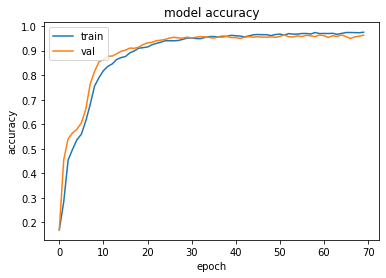

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

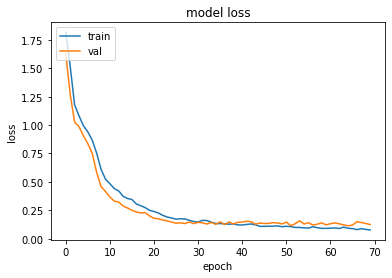

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()